somewhere else, do:
```
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
#setup -t b1813 ip_diffim
#setup -k -r .
setup -t 1813 -r .
scons
```

then you will want to add `$HOME/lsstsw/miniconda/lib/python2.7/site-packages` to your `PYTHONPATH` in order to be able to import `joblib` and friends.

now edit and run the code in here.

In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

from joblib import Parallel, delayed  
import multiprocessing

In [2]:
import sys
import numpy as np

import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

np.random.seed(666)

In [3]:
## Code updated from lsstsw/build/ip_diffim/tests/dipole.py

## Old code used a double gaussian psf which has the problem that it is pixel-oriented.
## Let's use afwMath.DoubleGaussianFunction2D() instead...
## Change parameterization to pixels - separation (in pixels) and psfWidth (pixels)

## Weird behavior, this fails the dipole lobes are not offset from each other in y direction (hence the +0.05 below...)
## or else we need to use 1,1 in the fpSet.merge() call below (instead of 0,0 which was in the original code)

def createDipole(w=100, h=100, xc=50., yc=50., separation=2.4, rotAngle=0.0, flux=3000.0, psfWidth=2.0, verbose=False,
                 display=False):  ## fracOffset = 1.2, psfSize=17, 
    # Make random noise image: set image plane to normal distribution
    image = afwImage.MaskedImageF(w,h)
    image.set(0)
    array = image.getImage().getArray()
    array[:,:] = np.random.randn(w,h)
    # Set variance to 1.0 -- TODO, should set variance after adding flux
    var   = image.getVariance()
    var.set(1.0)
        
    # Create Psf for dipole creation and measurement. Need a psf object too (for source detection below)
    psfSize = int(psfWidth * 20.) + 1
    psf = measAlg.DoubleGaussianPsf(psfSize, psfSize, psfWidth, psfWidth*1.75, 0.1) ## 2.0, 3.5, 0.1)
    generator = afwMath.DoubleGaussianFunction2D(psfWidth, psfWidth*1.75, 0.1)    

    psfim = psf.computeImage().convertF()
    psfim *= flux / np.sum(psfim.getArray())
    psfw, psfh = psfim.getDimensions()
    psfSum = np.sum(psfim.getArray())

    if display:
        #ds9.mtv(image, frame=1, title="Original image")
        #ds9.mtv(image.getVariance(), frame=2, title="Original variance")
        psf_arr = psf.computeImage().convertF().getArray()
        plt.imshow(np.rot90(psf_arr), cmap='gray', extent=(0,psfSize-1,0,psfSize-1), interpolation='none')
        plt.plot(psfw//2, psfw//2, 'bo')
        plt.title("PSF")
        plt.show()

    # Create the dipole separated by pixels instead of the old fracOffset of Psf FWHM
    # Assume rotAngle is in degrees
    rotAngRad = rotAngle / 180. * np.pi
    array  = image.getImage().getArray()
    xp, yp = xc + separation/2. * np.cos(rotAngRad), yc + separation/2. * np.sin(rotAngRad)
    imPos = np.ndarray( (w,h), buffer=np.array([ generator(i-xp,j-yp) for i in xrange(w) for j in xrange(h) ]) )
    array[:] += imPos/np.sum(imPos)*flux
    psfSum = np.sum(imPos/np.sum(imPos)*flux) # get more accurate input "flux"

    xn, yn = xc - separation/2. * np.cos(rotAngRad), yc - separation/2. * np.sin(rotAngRad)
    imNeg = np.ndarray( (w,h), buffer=np.array([ generator(i-xn,j-yn) for i in xrange(w) for j in xrange(h) ]) )
    array[:] -= imNeg/np.sum(imNeg)*flux
    
    if verbose:
        print 'INPUT CENTROID: ', xc, yc
        print 'INPUT ANGLE: ', rotAngle, rotAngRad
        print 'INPUT POSITIVE CENTROID:', xp, yp
        print 'INPUT NEGATIVE CENTROID:', xn, yn
    dipoleCenters = {'pos': (xp, yp), 'neg': (xn, yn)}

    # Create an exposure, detect positive and negative peaks separately
    # Need to create a psf object anyway, so that's why we did it above, same parameters as the function.
    
    exp = afwImage.makeExposure(image)
    exp.setPsf(psf)

    if display:
        #ds9.mtv(image, frame=3, title="With dipole")
        img_arr, mask_arr, var_arr = exp.getMaskedImage().getArrays()
        plt.title("Original image with dipole")
        plt.imshow(np.rot90(img_arr), vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.plot(xp, yp, 'bx')
        plt.plot(xn, yn, 'bx')
        ##plt.show()
    
    config = measAlg.SourceDetectionConfig()
    config.thresholdPolarity = "both"
    config.reEstimateBackground = True
    schema = afwTable.SourceTable.makeMinimalSchema()
    task = measAlg.SourceDetectionTask(schema, config=config)
    table = afwTable.SourceTable.make(schema)
    results = task.makeSourceCatalog(table, exp)
#     if display:
#         ds9.mtv(image, frame=4, title="Detection plane")
        
    # Merge them together
    assert(len(results.sources) == 2)
    fpSet = results.fpSets.positive
    fpSet.merge(results.fpSets.negative, 1, 1, False) ## note used to be tGrow=0, rGrow=0, but sometimes sources were not merged.
    sources = afwTable.SourceCatalog(table)
    fpSet.makeSources(sources)
    assert(len(sources) == 1)
    s = sources[0]
    assert(len(s.getFootprint().getPeaks()) == 2)

    if verbose:
        for pk in s.getFootprint().getPeaks():
            print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx()

    if display:
        ## first overlay the fp centers on the input image and show it.
        for pk in s.getFootprint().getPeaks():
            plt.plot(pk.getIy(), pk.getIx(), 'rx')
        plt.show()

        img_arr, mask_arr, var_arr = exp.getMaskedImage().getArrays()
        plt.title("Detection plane")
        plt.imshow(np.rot90(mask_arr), vmin=-100, vmax=100, cmap='gray', extent=(0,99,0,99), interpolation='none')
        for pk in s.getFootprint().getPeaks():
            plt.plot(pk.getIy(), pk.getIx(), 'rx')
        plt.show()
        
    return psf, psfSum, exp, s, dipoleCenters

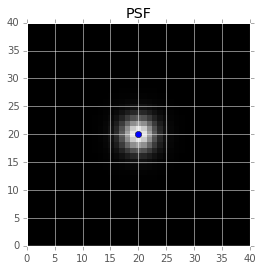

INPUT CENTROID:  50 50
INPUT ANGLE:  0.0 0.0
INPUT POSITIVE CENTROID: 51.2 50.0
INPUT NEGATIVE CENTROID: 48.8 50.0
FOOTPRINT CENTER: 53 50
FOOTPRINT CENTER: 47 50


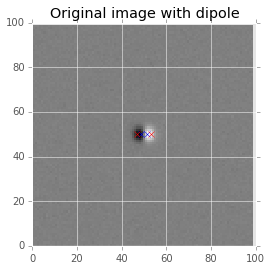

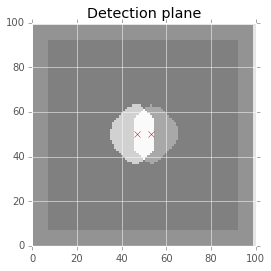

3000.0 {'neg': (48.799999999999997, 50.0), 'pos': (51.200000000000003, 50.0)}
CENTROID:  (50.0, 50.0)


In [4]:
#w, h = 100, 100 # size of image
#xc, yc = 50, 50 # location of center of dipole
psf, psfSum, exposure, s, dipoleCenters = createDipole(100, 100, 50, 50, separation=2.4, rotAngle=0., verbose=True, display=True)
print psfSum, dipoleCenters
dipoleCentroid = (np.mean([dipoleCenters['neg'][0], dipoleCenters['pos'][0]]), np.mean([dipoleCenters['neg'][1], dipoleCenters['pos'][1]]))
print 'CENTROID: ', dipoleCentroid

In [5]:
## I think this is the meat of the code that runs the measurement. How do I get the complete set of (fitted) parameters out? 
## THat is the question!
## OK, figured it out, see below...
def measureDipole(s, exp):
    msConfig = ipDiffim.DipoleMeasurementConfig()
    schema = afwTable.SourceTable.makeMinimalSchema()
    schema.addField("centroid_x", type=float)
    schema.addField("centroid_y", type=float)
    schema.addField("centroid_flag", type='Flag')
    task = ipDiffim.DipoleMeasurementTask(schema, config=msConfig)
    measCat = afwTable.SourceCatalog(schema)
    measCat.defineCentroid("centroid")
    source = measCat.addNew()
    source.set("centroid_x", dipoleCentroid[0])
    source.set("centroid_y", dipoleCentroid[1])
    source.setFootprint(s.getFootprint())

    #print 'DIPOLE: ', source.get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
    # Then run the default SFM task.  Results not checked
    task.run(measCat, exp)
    return measCat  ##[0] 

OK, I see that measureDipole is slow because of the psf fitting - in `DipoleAlgorithms.cc`. It seems to take nearly 1s for some fits (especially for closely-separated dipoles).

UPDATE - after compiling with O3, the dipole fitting is ~60ms now!

Why is it slow? Possible reasons:

1. `PsfDipoleFlux::chi2()` computes the PSF *image* (pos. and neg.) to compute the model, rather than using something like `afwMath.DoubleGaussianFunction2D()` as I do above. Or if that is not possible (may need to use a pixelated input PSF) then speed up the computation of the dipole model image (right now it uses multiple vectorized function calls).
2. It spends a lot of time floating around near the minimum and perhaps can be cut off more quickly (note this could be caused by (1.)
3. Perhaps its starting parameters (derived from the naive coordinates) could be made more accurate. At least it looks like the starting flux values are being set way too low (looks like +/- 22.0, should be ~3000 -- how is that being set?)
4. it computes chi2 over the entire subimage (confirm this?) rather than the inner 2,3,4, or 5 sigma of the PSF (or even better within the source's footprint(s)

Need to check out -- maybe because dipole fit is so slow, it's not enabled in the main pipelines, thus it uses the naive method by default which is inaccurate.

Note: It seems that the dipole fit is a lot faster for dipoles of greater separation than for those that are closer (it seems the optimization [minuit]) takes longer to converge).

But for now, let's just test the algorithm and worry about timing later.

In [6]:
#print 'DIPOLE: ' + s.get(dipoleFlag)
%timeit measureDipole(s, exposure)
sources = measureDipole(s, exposure)
print 'DIPOLE: ', sources[0].get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
source = sources[0]
fp     = source.getFootprint()
peaks  = fp.getPeaks()
speaks = [(p.getPeakValue(), p) for p in peaks]
speaks.sort()
dpeaks = [speaks[0][1], speaks[-1][1]]
print dpeaks
##print source.schema
print source.getCentroid() ## This just returns the values set in the "source.set("centroid_x", xc), ..." lines... ??
print source.get("ip_diffim_NaiveDipoleCentroid_pos_x"), source.get("ip_diffim_NaiveDipoleCentroid_pos_y"), \
    source.get("ip_diffim_NaiveDipoleCentroid_neg_x"), source.get("ip_diffim_NaiveDipoleCentroid_neg_y")
print source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"), \
    source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y")
print source.get("ip_diffim_PsfDipoleFlux_pos_flux"), source.get("ip_diffim_PsfDipoleFlux_neg_flux")

10 loops, best of 3: 55.2 ms per loop
DIPOLE:  1.0
[2: (50,47)  (50.000,47.000), 1: (50,53)  (50.000,53.000)]
(50, 50)
50.0065460205 52.8243598938 49.9911727905 47.1865196228
49.9987430753 51.264007873 49.9924651094 48.7466766234
2881.51511787 -2883.31609458


In [7]:
## provides (S/N, position, orientation) of measured dipoles
dpAnalysis = ipDiffim.DipoleAnalysis()
sn, centroid, orientation = dpAnalysis(source)
print sn, centroid, orientation

69.5535909869 (49.996, 50.005) 0.00249389 rad


In [8]:
## deblend a source as a dipole, and return a new source with deblended footprints.
dpDeblender = ipDiffim.DipoleDeblender()
deblendedSource = dpDeblender(source, exposure)
print deblendedSource.getCentroid()
print deblendedSource.get("ip_diffim_NaiveDipoleCentroid_pos_x"), deblendedSource.get("ip_diffim_NaiveDipoleCentroid_pos_y"), \
    deblendedSource.get("ip_diffim_NaiveDipoleCentroid_neg_x"), deblendedSource.get("ip_diffim_NaiveDipoleCentroid_neg_y")
print deblendedSource.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), deblendedSource.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"), \
    deblendedSource.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), deblendedSource.get("ip_diffim_PsfDipoleFlux_neg_centroid_y")
print deblendedSource.get("ip_diffim_PsfDipoleFlux_pos_flux"), deblendedSource.get("ip_diffim_PsfDipoleFlux_neg_flux")

(50, 50)
50.0065460205 52.8243598938 49.9911727905 47.1865196228
49.9987430753 51.264007873 49.9924651094 48.7466766234
2881.51511787 -2883.31609458


In [9]:
# Recreate the simultaneous joint Psf fit in python
## This just fits for the flux of the dipole lobes, given a pair of input centroids.
def _makeModel(exposure, psf, fp, negCenter, posCenter, display=False):
    negPsf = psf.computeImage(negCenter).convertF()
    posPsf = psf.computeImage(posCenter).convertF()
    negPeak = psf.computePeak(negCenter)
    posPeak = psf.computePeak(posCenter)
    negPsf /= negPeak
    posPsf /= posPeak

    model    = afwImage.ImageF(fp.getBBox())
    negModel = afwImage.ImageF(fp.getBBox())
    posModel = afwImage.ImageF(fp.getBBox())

    # The center of the Psf should be at negCenter, posCenter
    negPsfBBox = negPsf.getBBox()
    posPsfBBox = posPsf.getBBox()
    modelBBox  = model.getBBox()

    # Portion of the negative Psf that overlaps the montage
    negOverlapBBox = afwGeom.Box2I(negPsfBBox)
    negOverlapBBox.clip(modelBBox)
    #self.assertFalse(negOverlapBBox.isEmpty())

    # Portion of the positivePsf that overlaps the montage
    posOverlapBBox = afwGeom.Box2I(posPsfBBox)
    posOverlapBBox.clip(modelBBox)
    #self.assertFalse(posOverlapBBox.isEmpty())

    negPsfSubim    = type(negPsf)(negPsf, negOverlapBBox)
    modelSubim     = type(model)(model, negOverlapBBox)
    negModelSubim  = type(negModel)(negModel, negOverlapBBox)
    modelSubim    += negPsfSubim  # just for debugging
    negModelSubim += negPsfSubim  # for fitting

    posPsfSubim    = type(posPsf)(posPsf, posOverlapBBox)
    modelSubim     = type(model)(model, posOverlapBBox)
    posModelSubim  = type(posModel)(posModel, posOverlapBBox)
    modelSubim    += posPsfSubim
    posModelSubim += posPsfSubim

    data = afwImage.ImageF(exposure.getMaskedImage().getImage(), fp.getBBox())
    var = afwImage.ImageF(exposure.getMaskedImage().getVariance(), fp.getBBox())
    matrixNorm = 1. / np.sqrt(np.median(var.getArray()))

    posPsfSum = np.sum(posPsf.getArray())
    negPsfSum = np.sum(negPsf.getArray())

    M = np.array((np.ravel(negModel.getArray()), np.ravel(posModel.getArray()))).T.astype(np.float64)
    B = np.array((np.ravel(data.getArray()))).astype(np.float64)
    M *= matrixNorm
    B *= matrixNorm

    # Numpy solution
    fneg0, fpos0 = np.linalg.lstsq(M, B)[0]

    # Afw solution
    lsq = afwMath.LeastSquares.fromDesignMatrix(M, B, afwMath.LeastSquares.DIRECT_SVD)
    fneg, fpos = lsq.getSolution()

    # Should be exaxtly the same as each other
    #self.assertAlmostEqual(1e-2*fneg0,  1e-2*fneg)
    #self.assertAlmostEqual(1e-2*fpos0,  1e-2*fpos)

    # Recreate model
    fitted  = afwImage.ImageF(fp.getBBox())
    negFit  = type(negPsf)(negPsf, negOverlapBBox, afwImage.PARENT, True)
    negFit *= float(fneg)
    posFit  = type(posPsf)(posPsf, posOverlapBBox, afwImage.PARENT, True)
    posFit *= float(fpos)

    fitSubim  = type(fitted)(fitted, negOverlapBBox)
    fitSubim += negFit
    fitSubim  = type(fitted)(fitted, posOverlapBBox)
    fitSubim += posFit
    
    if display:
    #    ds9.mtv(model, frame=5, title="Unfitted model")
    #    ds9.mtv(data, frame=6, title="Data")
        fig = plt.figure()
        a = fig.add_subplot(1,3,1)
        plt.imshow(np.rot90(model.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Unfitted model (footprint?)')
        #plt.show()
        a = fig.add_subplot(1,3,2)
        plt.imshow(np.rot90(data.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Data')
        #plt.show()

    #if display:
    #    ds9.mtv(fitted, frame=7, title="Fitted model")
        a = fig.add_subplot(1,3,3)
        plt.imshow(np.rot90(fitted.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Fitted model')
        plt.show()

    fitted   -= data

    if display:
    #    ds9.mtv(fitted, frame=8, title="Residuals")
        plt.imshow(np.rot90(fitted.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Residuals')
        plt.show()

    fitted   *= fitted
    fitted   /= var

    if display:
    #    ds9.mtv(fitted, frame=9, title="Chi2")
        plt.imshow(np.rot90(fitted.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Chi2')
        plt.show()

    return fneg, negPsfSum, fpos, posPsfSum, fitted

(50, 53) (50, 47)


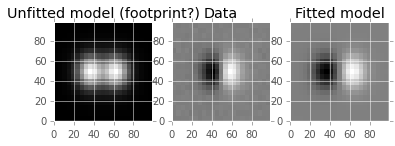

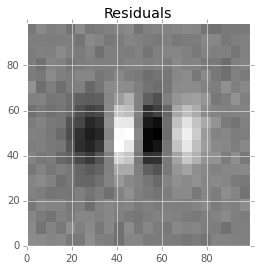

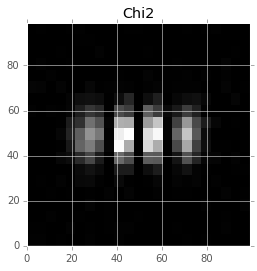

0.533336356824 0.532535590727


In [10]:
negCenter = afwGeom.Point2D(dpeaks[0].getFx(), dpeaks[0].getFy())
posCenter = afwGeom.Point2D(dpeaks[1].getFx(), dpeaks[1].getFy())
print posCenter, negCenter

fneg, negPsfSum, fpos, posPsfSum, residIm = _makeModel(exposure, psf, fp, negCenter, posCenter, display=True)

# Should be close to the same as the inputs; as fracOffset
# gets smaller this will be worse.
print -1e-2*fneg,  1e-2*fpos

## Looks like ACB's test code uses the integral value for the naive dipole fitted peak centroid...?

(49.999, 51.264) (49.992, 48.747)


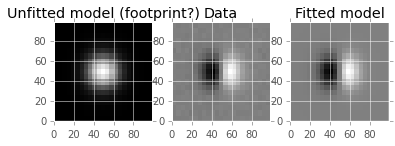

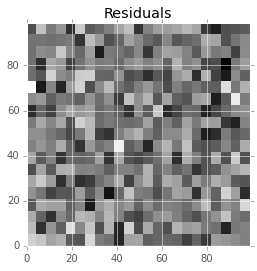

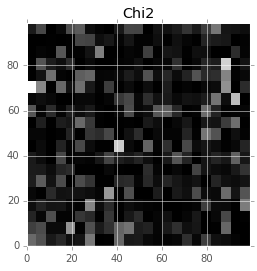

0.966092248332 0.965490408111


In [11]:
negCenter = afwGeom.Point2D(source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y"))
posCenter = afwGeom.Point2D(source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"))
print posCenter, negCenter

fneg, negPsfSum, fpos, posPsfSum, residIm = _makeModel(exposure, psf, fp, negCenter, posCenter, display=True)

# Should be close to the same as the inputs
print -1e-2*fneg,  1e-2*fpos

In [12]:
from collections import namedtuple
resultsOutput = namedtuple('resultsOutput', 
        'inputCentroidX inputCentroidY inputSeparation inputRotation inputFlux inputPosCentroidX inputPosCentroidY inputNegCentroidX inputNegCentroidY psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')

def makeDipoleAndTestDipoleFit(w=100, h=100, xc=50., yc=50., separation=2.4, rotAngle=0.0, flux=3000.0, psfWidth=2.0, verbose=False):
    psf, psfSum, exposure, s, dipoleCenters = createDipole(w, h, xc, yc, separation=separation, rotAngle=rotAngle, 
                                                           flux=flux, psfWidth=psfWidth, verbose=verbose, display=False)
    if verbose: print psfSum, dipoleCenters
    dipoleCentroid = (np.mean([dipoleCenters['pos'][0], dipoleCenters['neg'][0]]), np.mean([dipoleCenters['pos'][1], dipoleCenters['neg'][1]]))
    if verbose: print 'CENTROID: ', dipoleCentroid
    
    sources = measureDipole(s, exposure)
    if verbose: print 'DIPOLE: ', sources[0].get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
    source = sources[0]
    fp     = source.getFootprint()
    peaks  = fp.getPeaks()
    speaks = [(p.getPeakValue(), p) for p in peaks]
    speaks.sort()
    dpeaks = [speaks[0][1], speaks[-1][1]]
    if verbose: 
        print dpeaks
        ##print source.schema
        print source.getCentroid() ## This just returns the values set in the "source.set("centroid_x", xc), ..." lines... ??
        print source.get("ip_diffim_NaiveDipoleCentroid_pos_x"), source.get("ip_diffim_NaiveDipoleCentroid_pos_y"), \
            source.get("ip_diffim_NaiveDipoleCentroid_neg_x"), source.get("ip_diffim_NaiveDipoleCentroid_neg_y")
        print source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"), \
            source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y")
        print source.get("ip_diffim_PsfDipoleFlux_pos_flux"), source.get("ip_diffim_PsfDipoleFlux_neg_flux")  
    
    ## provides (S/N, position, orientation) of measured dipoles
    dpAnalysis = ipDiffim.DipoleAnalysis()
    sn, centroid, orientation = dpAnalysis(source)
    if verbose: print sn, centroid, orientation
        
    out = resultsOutput(xc, yc, separation, rotAngle, flux,
        dipoleCenters['pos'][0], dipoleCenters['pos'][1], dipoleCenters['neg'][0], dipoleCenters['neg'][1], 
        source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"),
        source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y"),
        source.get("ip_diffim_PsfDipoleFlux_pos_flux"), source.get("ip_diffim_PsfDipoleFlux_neg_flux"),
        centroid.getX(), centroid.getY(), orientation, sn)
    
#     return (source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"), 
#             source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y"), 
#             sn, centroid, orientation)
    return out

In [13]:
makeDipoleAndTestDipoleFit(w=100, h=100, xc=50., yc=50., psfWidth=2.0, separation=2.4, rotAngle=0.0, flux=3000.0, verbose=True)

INPUT CENTROID:  50.0 50.0
INPUT ANGLE:  0.0 0.0
INPUT POSITIVE CENTROID: 51.2 50.0
INPUT NEGATIVE CENTROID: 48.8 50.0
FOOTPRINT CENTER: 53 50
FOOTPRINT CENTER: 47 50
3000.0 {'neg': (48.799999999999997, 50.0), 'pos': (51.200000000000003, 50.0)}
CENTROID:  (50.0, 50.0)
DIPOLE:  1.0
[16: (50,47)  (50.000,47.000), 15: (50,53)  (50.000,53.000)]
(50, 50)
50.0018768311 52.8285865784 50.0133247375 47.184425354
49.9989663445 51.2217263887 50.0115281152 48.7831582751
2953.94502192 -2944.56573239
63.5496354041 (50.005, 50.002) -0.00515124 rad


resultsOutput(inputCentroidX=50.0, inputCentroidY=50.0, inputSeparation=2.4, inputRotation=0.0, inputFlux=3000.0, inputPosCentroidX=51.200000000000003, inputPosCentroidY=50.0, inputNegCentroidX=48.799999999999997, inputNegCentroidY=50.0, psfFitPosCentroidX=49.99896634451826, psfFitPosCentroidY=51.221726388678626, psfFitNegCentroidX=50.011528115193784, psfFitNegCentroidY=48.78315827507966, psfFitPosFlux=2953.9450219228365, psfFitNegFlux=-2944.565732391194, psfFitCentroidX=50.005247229856025, psfFitCentroidY=50.00244233187914, psfFitOrientation=-0.00515124 rad, psfFitSignaltoNoise=63.549635404067701)

In [14]:
makeDipoleAndTestDipoleFit(w=100, h=100, xc=50., yc=50., psfWidth=2.0, separation=2.4, rotAngle=90.0, flux=3000.0)

resultsOutput(inputCentroidX=50.0, inputCentroidY=50.0, inputSeparation=2.4, inputRotation=90.0, inputFlux=3000.0, inputPosCentroidX=50.0, inputPosCentroidY=51.200000000000003, inputNegCentroidX=50.0, inputNegCentroidY=48.799999999999997, psfFitPosCentroidX=51.18403430881684, psfFitPosCentroidY=49.99420143640869, psfFitNegCentroidX=48.807105851428645, psfFitNegCentroidY=49.990879730772164, psfFitPosFlux=3028.4464321635614, psfFitNegFlux=-3049.9974848282595, psfFitCentroidX=49.99557008012275, psfFitCentroidY=49.992540583590426, psfFitOrientation=1.5694 rad, psfFitSignaltoNoise=60.527646749939812)

Note the output seems to have switched X and Y -- is this on purpose or my misunderstanding?

But for now we will just compare inputX with outputY and vice versa.

In [15]:
results = [makeDipoleAndTestDipoleFit(w=100, h=100, xc=50., yc=50., psfWidth=2.0, separation=2.4, rotAngle=0.0, flux=3000.0)
          for i in xrange(10)]

In [16]:
print [res.psfFitPosCentroidY for res in results]
results[0]._asdict()

[51.22495690838583, 51.17715181308433, 51.208756622061436, 51.18409839980959, 51.218046464176055, 51.23562644304908, 51.282518368212585, 51.272706394570434, 51.29360081259293, 51.20477859782112]


OrderedDict([('inputCentroidX', 50.0),
             ('inputCentroidY', 50.0),
             ('inputSeparation', 2.4),
             ('inputRotation', 0.0),
             ('inputFlux', 3000.0),
             ('inputPosCentroidX', 51.200000000000003),
             ('inputPosCentroidY', 50.0),
             ('inputNegCentroidX', 48.799999999999997),
             ('inputNegCentroidY', 50.0),
             ('psfFitPosCentroidX', 50.010575715900934),
             ('psfFitPosCentroidY', 51.22495690838583),
             ('psfFitNegCentroidX', 50.01065543553916),
             ('psfFitNegCentroidY', 48.77573037831541),
             ('psfFitPosFlux', 2930.220780633984),
             ('psfFitNegFlux', -2942.6117186812335),
             ('psfFitCentroidX', 50.010615575720045),
             ('psfFitCentroidY', 50.00034364335062),
             ('psfFitOrientation', -3.25489e-05 rad),
             ('psfFitSignaltoNoise', 65.158205456892389)])

In [17]:
import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

In [18]:
df = pd.DataFrame([res._asdict() for res in results])
sizeme(df.head())

,inputCentroidX,inputCentroidY,inputFlux,inputNegCentroidX,inputNegCentroidY,inputPosCentroidX,inputPosCentroidY,inputRotation,inputSeparation,psfFitCentroidX,psfFitCentroidY,psfFitNegCentroidX,psfFitNegCentroidY,psfFitNegFlux,psfFitOrientation,psfFitPosCentroidX,psfFitPosCentroidY,psfFitPosFlux,psfFitSignaltoNoise
0,50,50,3000,48.8,50,51.2,50,0,2.4,50.010616,50.000344,50.010655,48.775730,-2942.611719,-3.25489e-05 rad,50.010576,51.224957,2930.220781,65.158205
1,50,50,3000,48.8,50,51.2,50,0,2.4,49.993365,50.014233,49.993422,48.851314,-3068.752728,-4.91553e-05 rad,49.993308,51.177152,3078.762712,55.543058
2,50,50,3000,48.8,50,51.2,50,0,2.4,50.002248,49.996627,50.000643,48.784498,-2975.997474,0.00132425 rad,50.003853,51.208757,2976.145904,62.587417
3,50,50,3000,48.8,50,51.2,50,0,2.4,50.016309,49.991841,50.013799,48.799583,-3031.493817,0.00210514 rad,50.018819,51.184098,3034.533291,59.659974
4,50,50,3000,48.8,50,51.2,50,0,2.4,50.000665,49.988624,49.994988,48.759201,-2960.191495,0.00461796 rad,50.006343,51.218046,2946.808702,64.969969


In [19]:
sizeme(df.describe())

,inputCentroidX,inputCentroidY,inputFlux,inputNegCentroidX,inputNegCentroidY,inputPosCentroidX,inputPosCentroidY,inputRotation,inputSeparation,psfFitCentroidX,psfFitCentroidY,psfFitNegCentroidX,psfFitNegCentroidY,psfFitNegFlux,psfFitPosCentroidX,psfFitPosCentroidY,psfFitPosFlux,psfFitSignaltoNoise
count,10,10,10,10.0,10,10.0,10,10,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,50,50,3000,48.8,50,51.2,50,0,2.400000e+00,50.001706,50.003682,50.001177,48.777140,-2950.079454,50.002235,51.230224,2951.329951,65.418366
std,0,0,0,0.0,0,0.0,0,0,4.681111e-16,0.010398,0.010678,0.012229,0.040764,77.018470,0.010318,0.040571,75.886713,6.489114
min,50,50,3000,48.8,50,51.2,50,0,2.400000e+00,49.988743,49.988624,49.981354,48.706426,-3068.752728,49.985666,51.177152,2823.507422,55.543058
25%,50,50,3000,48.8,50,51.2,50,0,2.400000e+00,49.992628,49.997474,49.993813,48.755104,-2986.808039,49.994609,51.205773,2900.590135,61.737964
50%,50,50,3000,48.8,50,51.2,50,0,2.400000e+00,50.001457,50.000391,49.999871,48.780114,-2967.240952,50.001863,51.221502,2961.477303,64.511304
75%,50,50,3000,48.8,50,51.2,50,0,2.400000e+00,50.009072,50.012258,50.010243,48.798712,-2890.938209,50.009517,51.263436,2979.484493,68.936590
max,50,50,3000,48.8,50,51.2,50,0,2.400000e+00,50.017091,50.022112,50.020505,48.851314,-2829.550072,50.018819,51.293601,3078.762712,76.874269


Test: do 10 repetitions at slowing increasing separations. This will probably fail due to exceptions being raised. Note these are all horizontally-aligned dipoles.

### Horizontally-aligned dipoles with increasing separation

In [20]:
results = [makeDipoleAndTestDipoleFit(w=100, h=100, xc=50., yc=50., psfWidth=2.0, separation=sep, rotAngle=0.0, flux=3000.0)
          for i in xrange(10) for sep in np.arange(0.2,5.0,0.2)]

In [21]:
df = pd.DataFrame([res._asdict() for res in results])
sizeme(df.head())

,inputCentroidX,inputCentroidY,inputFlux,inputNegCentroidX,inputNegCentroidY,inputPosCentroidX,inputPosCentroidY,inputRotation,inputSeparation,psfFitCentroidX,psfFitCentroidY,psfFitNegCentroidX,psfFitNegCentroidY,psfFitNegFlux,psfFitOrientation,psfFitPosCentroidX,psfFitPosCentroidY,psfFitPosFlux,psfFitSignaltoNoise
0,50,50,3000,49.9,50,50.1,50,0,0.2,50.190829,49.880329,50.246474,48.501695,-246.336641,-0.0403409 rad,50.135183,51.258963,229.371204,7.694102
1,50,50,3000,49.8,50,50.2,50,0,0.4,49.984637,50.030495,49.989989,49.560208,-1274.122934,-0.0113806 rad,49.979284,50.500783,1266.248493,3.591305
2,50,50,3000,49.7,50,50.3,50,0,0.6,50.054557,50.018761,50.057293,49.505379,-1756.128024,-0.00532898 rad,50.051821,50.532142,1757.161181,5.078968
3,50,50,3000,49.6,50,50.4,50,0,0.8,49.967433,49.979805,49.963262,49.662734,-3776.597942,0.0131532 rad,49.971603,50.296876,3774.042167,4.598123
4,50,50,3000,49.5,50,50.5,50,0,1.0,50.071031,50.008048,50.073907,49.383414,-2406.999194,-0.00460512 rad,50.068154,50.632682,2411.605728,9.090020


In [22]:
sizeme(df.groupby('inputSeparation').mean().head())

,inputCentroidX,inputCentroidY,inputFlux,inputNegCentroidX,inputNegCentroidY,inputPosCentroidX,inputPosCentroidY,inputRotation,psfFitCentroidX,psfFitCentroidY,psfFitNegCentroidX,psfFitNegCentroidY,psfFitNegFlux,psfFitPosCentroidX,psfFitPosCentroidY,psfFitPosFlux,psfFitSignaltoNoise
inputSeparation,,,,,,,,,,,,,,,,,
0.2,50,50,3000,49.9,50,50.1,50,0,50.032463,49.947184,50.027269,49.470593,-5348.724402,50.037657,50.423776,5345.741717,56.820612
0.4,50,50,3000,49.8,50,50.2,50,0,49.984477,50.012460,49.980779,49.466647,-1269.479184,49.988175,50.558274,1273.230214,3.391668
0.6,50,50,3000,49.7,50,50.3,50,0,50.010627,50.027560,50.013424,49.587562,-2137.480037,50.007829,50.467557,2140.340444,4.261601
0.8,50,50,3000,49.6,50,50.4,50,0,49.996596,50.000860,49.995508,49.481399,-2468.020639,49.997685,50.520321,2468.251109,6.441358
1.0,50,50,3000,49.5,50,50.5,50,0,49.999034,49.995902,49.999214,49.475062,-2962.976134,49.998853,50.516742,2964.273593,8.023339


/Users/dreiss/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


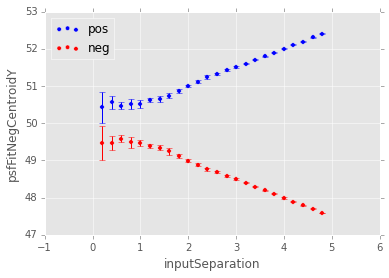

In [23]:
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosCentroidY', kind='scatter', yerr=tmp_df2['psfFitPosCentroidY'], color='blue', label='pos')
tmp_df.plot(x='inputSeparation', y='psfFitNegCentroidY', kind='scatter', yerr=tmp_df2['psfFitNegCentroidY'], color='red', label='neg', ax=ax)

In [24]:
df['diffCentroidPos'] = df.psfFitPosCentroidY - df.inputPosCentroidX
df['diffCentroidNeg'] = df.psfFitNegCentroidY - df.inputNegCentroidX

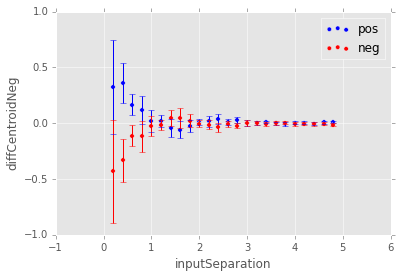

In [25]:
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='diffCentroidPos', kind='scatter', yerr=tmp_df2['diffCentroidPos'], color='blue', label='pos')
tmp_df.plot(x='inputSeparation', y='diffCentroidNeg', kind='scatter', yerr=tmp_df2['diffCentroidNeg'], color='red', label='neg', ax=ax)

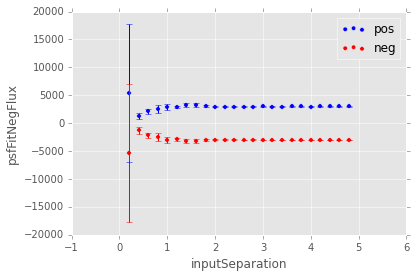

In [26]:
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosFlux', kind='scatter', yerr=tmp_df2['psfFitPosFlux'], color='blue', label='pos')
tmp_df.plot(x='inputSeparation', y='psfFitNegFlux', kind='scatter', yerr=tmp_df2['psfFitNegFlux'], color='red', label='neg', ax=ax)

Hmm, it looks like it sometime switches which is the pos- and neg- lobes. Let's take a closer look...

In [27]:
df[df.psfFitPosFlux < 0.]
df.ix[np.argmax(df.psfFitNegFlux)]

inputCentroidX                     50
inputCentroidY                     50
inputFlux                        3000
inputNegCentroidX                49.9
inputNegCentroidY                  50
inputPosCentroidX                50.1
inputPosCentroidY                  50
inputRotation                       0
inputSeparation                   0.2
psfFitCentroidX               50.1908
psfFitCentroidY               49.8803
psfFitNegCentroidX            50.2465
psfFitNegCentroidY            48.5017
psfFitNegFlux                -246.337
psfFitOrientation      -0.0403409 rad
psfFitPosCentroidX            50.1352
psfFitPosCentroidY             51.259
psfFitPosFlux                 229.371
psfFitSignaltoNoise            7.6941
diffCentroidPos               1.15896
diffCentroidNeg               -1.3983
Name: 0, dtype: object

OK, see notebook #3a. to see what might be going on (answer - it's just that at close separations for big FWHM, it's hard.)

Try it again, this time setting different orientations as well. Next time we'll also test it as a function of source flux.

### Different orientations

In [28]:
from joblib import Parallel, delayed  
import multiprocessing

## Cool, get argument names for the function, and turn it into a named tuple...
varNames = makeDipoleAndTestDipoleFit.__code__.co_varnames[:makeDipoleAndTestDipoleFit.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)

inputs = [varTuple(w=100, h=100, xc=50., yc=50., psfWidth=2.0, separation=sep, rotAngle=rot, 
                         flux=3000.0, verbose=False) for rot in orientations for sep in separations]

def processInput(i):
    #print i.separation, i.rotAngle
    output = makeDipoleAndTestDipoleFit(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfWidth=i.psfWidth, separation=i.separation, 
                               rotAngle=i.rotAngle, flux=i.flux, verbose=i.verbose)
    return output


num_cores = multiprocessing.cpu_count() / 2
##print num_cores

# results2 = [makeDipoleAndTestDipoleFit(w=100, h=100, xc=50., yc=50., psfWidth=2.0, separation=sep, rotAngle=rot[i], 
#                                        flux=3000.0) for rot in orientations for sep in separations]
results2 = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
# results2 = [processInput(i) for i in inputs]

In [29]:
df = pd.DataFrame([res._asdict() for res in results2])
print df.shape
df['rmsCentroidPos'] = np.sqrt((df.inputPosCentroidX - df.psfFitPosCentroidY)**2. + \
                               (df.inputPosCentroidY - df.psfFitPosCentroidX)**2.)

df['rmsCentroidNeg'] = np.sqrt((df.inputNegCentroidX - df.psfFitNegCentroidY)**2. + \
                               (df.inputNegCentroidY - df.psfFitNegCentroidX)**2.)

#df['rmsCentroidPos2'] = np.sqrt((df.inputPosCentroidX - df.psfFitPosCentroidX)**2. + \
#                               (df.inputPosCentroidY - df.psfFitPosCentroidY)**2.)
#df['rmsCentroidNeg2'] = np.sqrt((df.inputNegCentroidX - df.psfFitNegCentroidX)**2. + \
#                               (df.inputNegCentroidY - df.psfFitNegCentroidY)**2.)
sizeme(df.head())

(240, 19)


,inputCentroidX,inputCentroidY,inputFlux,inputNegCentroidX,inputNegCentroidY,inputPosCentroidX,inputPosCentroidY,inputRotation,inputSeparation,psfFitCentroidX,...,psfFitNegCentroidX,psfFitNegCentroidY,psfFitNegFlux,psfFitOrientation,psfFitPosCentroidX,psfFitPosCentroidY,psfFitPosFlux,psfFitSignaltoNoise,rmsCentroidPos,rmsCentroidNeg
0,50,50,3000,49.9,50,50.1,50,0,0.2,49.705038,...,49.718431,49.409043,-464.461540,-0.020427 rad,49.691645,50.720183,475.730052,1.495908,0.692611,0.565968
1,50,50,3000,49.8,50,50.2,50,0,0.4,49.844785,...,49.849624,49.581974,-1354.389699,-0.0108392 rad,49.839945,50.474882,1364.284884,2.707351,0.318085,0.264855
2,50,50,3000,49.7,50,50.3,50,0,0.6,49.895037,...,49.898758,49.560264,-1974.319085,-0.0081181 rad,49.891317,50.476772,1983.936443,4.382114,0.207510,0.172558
3,50,50,3000,49.6,50,50.4,50,0,0.8,49.920560,...,49.923633,49.532144,-2496.365458,-0.00638223 rad,49.917486,50.495232,2505.868934,6.143031,0.126007,0.102159
4,50,50,3000,49.5,50,50.5,50,0,1.0,49.961477,...,49.963308,49.466488,-2852.704079,-0.00344271 rad,49.959647,50.529753,2850.834156,8.397085,0.050136,0.049693


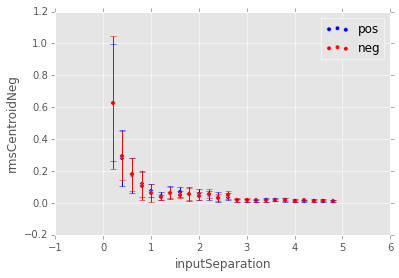

In [30]:
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], color='blue', label='pos')
tmp_df.plot(x='inputSeparation', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], color='red', label='neg', ax=ax)

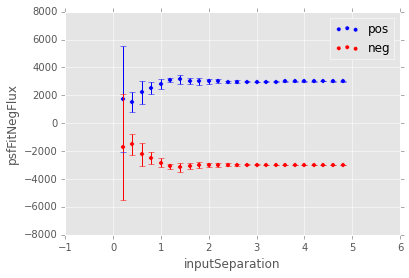

In [31]:
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosFlux', kind='scatter', yerr=tmp_df2['psfFitPosFlux'], color='blue', label='pos')
tmp_df.plot(x='inputSeparation', y='psfFitNegFlux', kind='scatter', yerr=tmp_df2['psfFitNegFlux'], color='red', label='neg', ax=ax)